In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout


input_files = ["file1.csv", "file2.csv", "file3.csv"]

temp_dir = "C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_"  # Thư mục lưu file tạm

input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

df = [dk.read_csv(input_file) for input_file in input_files]

['C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_file1.csv', 'C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_file2.csv', 'C:/Users/hoang/FileCSV_DACN_2025/ddos_dos_file3.csv']


In [2]:
batch_size = 512
ratio_test_all = 0.15

# from dask_ml.model_selection import train_test_split 
# # chia train test ratio 0.8:0.2 & random 
# train_df, test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)

def dask_to_tf_dataset(dask_df, batch_size, num_classes): 
    def generator():
        for batch in dask_df.to_delayed():
            batch=batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values
            y_onehot = to_categorical(y, num_classes=num_classes)  

            num_splits = max(1, len(X) // batch_size)  # Đảm bảo không chia nhỏ quá mức
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y_onehot, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
                
    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, 11), dtype=tf.int32),
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

In [3]:
# train_df1, test_df1 = df1.random_split([1 - ratio_test_all, ratio_test_all])
# train_df2, test_df2 = df2.random_split([1 - ratio_test_all, ratio_test_all])
# train_df3, test_df3 = df3.random_split([1 - ratio_test_all, ratio_test_all])
train_dfs = []
test_dfs = []
for dff in df:
    train_df, test_df =dff.random_split([1 - ratio_test_all, ratio_test_all])
    train_dfs.append(train_df)
    test_dfs.append(test_df)
   

train_gens = [dask_to_tf_dataset(train_df, 512, 11).repeat() for train_df in train_dfs]

test_gens = [dask_to_tf_dataset(test_df , 512, 11) for test_df in test_dfs]

In [4]:
import datetime
import numpy as np

#
from server import Server
from client import Client
num_servers = 1
num_clients = 3

active_servers_list  = ['server_'+str(i)\
                        for i in range(num_servers)]
active_clients_list  = ['client_'+str(i)\
                        for i in range(num_clients)]

print(active_servers_list)
print(active_clients_list)

agents_dict= {}
serverObjects={}
clientObjects={}
serverObjects = {server_name: Server(server_name=server_name, \
                        active_clients_list=active_clients_list) \
                        for server_name in active_servers_list}

clientObjects = {client_name: Client(client_name, train_gens[clientID], test_gens[clientID], \
                        active_clients_list = active_clients_list) \
                        for clientID, client_name in enumerate(active_clients_list)}

# lưu dict
agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

# init agents_dict vừa tạo vào client, server
for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

client_name = 'client_1'
print("Agent_Dict: ", agents_dict['client'][client_name])

server = agents_dict['server']['server_0']
print(server)

['server_0']
['client_0', 'client_1', 'client_2']
Agent_Dict:  <client.Client object at 0x00000253BA55E0D0>


In [ ]:
if __name__ == '__main__':
    server.InitLoop()
    server.final_statistics()

====================================== Đang chạy Iteration 1 ======================================
Input Shape: (46, 1)
Input Shape: (46, 1)
Input Shape: (46, 1)
Epoch 1/5
Epoch 1/5
Epoch 1/5
  386/23000 ━━━━━━━━━━━━━━━━━━━━ 5:58 16ms/step - accuracy: 0.1387 - loss: 2.4460

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

import numpy as np

X_tests = {}
Y_tests = {}

for i, client_name in enumerate(active_clients_list):
    X_test_list = []
    y_test_list = []

    for X_batch, y_batch in test_gens[i].as_numpy_iterator():
        # take(12000):
        X_test_list.append(X_batch)
        y_test_list.append(y_batch)  # .numpy()

        # Gộp tất cả batch lại
        X_test = np.concatenate(X_test_list, axis=0)
        y_test = np.concatenate(y_test_list, axis=0)

        # Nếu y_test đang ở dạng one-hot, chuyển về dạng số
        y_test = np.argmax(y_test, axis=1)

print(X_tests['client_2'])

In [ ]:
tempdirs = ["D:/DoAnChuyenNganh_Train/client_0_log/22h08p__25-03-2025/", "D:/DoAnChuyenNganh_Train/client_1_log/22h08p__25-03-2025/",  "D:/DoAnChuyenNganh_Train/client_2_log/22h08p__25-03-2025/"]


model_names =["model_1.h5", "model_2.h5", "model_3.h5"]
models = {}

for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i]+model_name) for model_name in model_names]

1609/1609 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
  47/1609 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1609/1609 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
  88/1609 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1609/1609 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


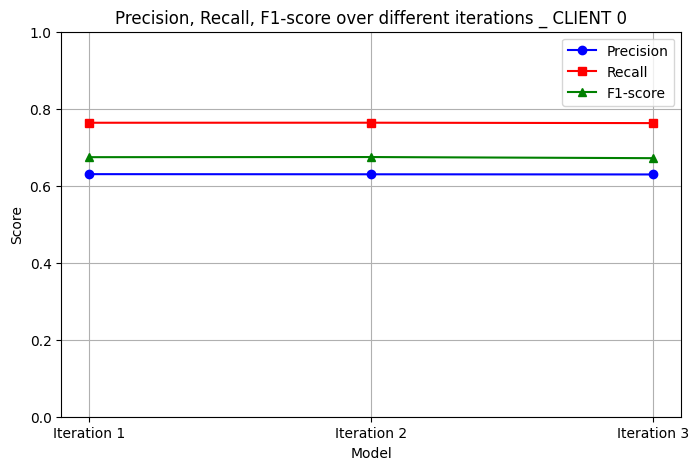

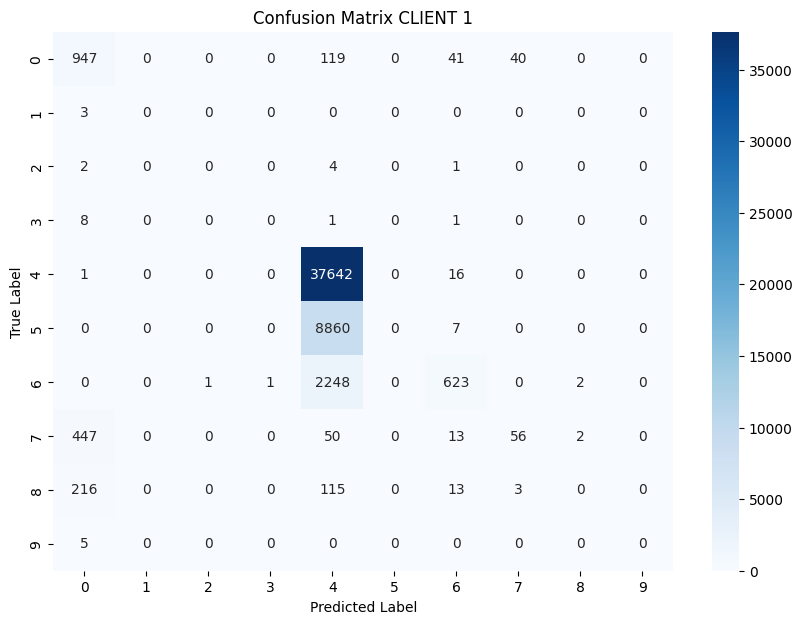

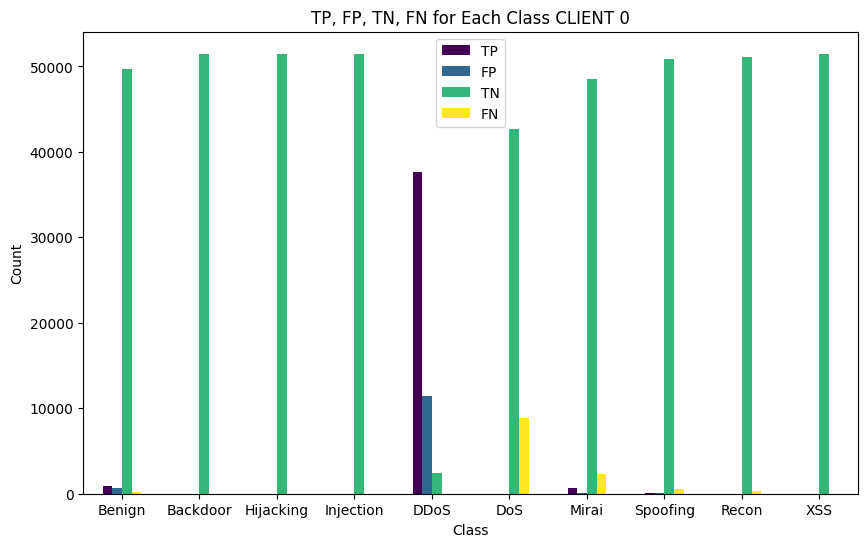

In [ ]:
# Client 0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

precisions = []
recalls = []
f1s = []

Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3']
for index in range(len(Iterations)):
    y_pred_prob = models['client_0'][index].predict(X_tests['client_0'])
    y_pred = y_pred_prob.argmax(axis=1)
    
    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_0'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_0'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_0'], y_pred, average='weighted'))
    
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()



cm = confusion_matrix(Y_tests['client_0'], y_pred)

    # Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


attack_types =["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]
metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(10, 6), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 0")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

3219/3219 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  38/3219 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3219/3219 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
  41/3219 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step   

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3219/3219 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Precision Score:  [0.6190944787646665, 0.6266401163147668, 0.6336233592422633]
Recall Score:  [0.7595401316683821, 0.7627250305866817, 0.7645311013147418]
F1 Score:  [0.6721414250711037, 0.6728537962512727, 0.6740743027179562]


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


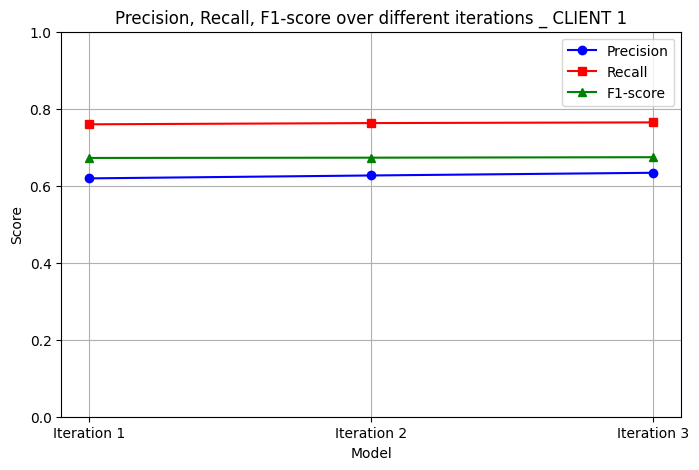

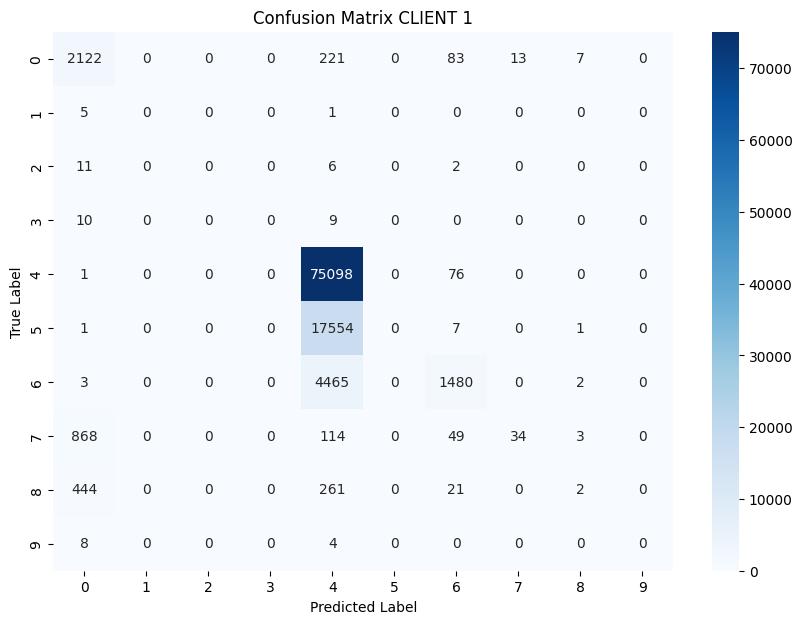

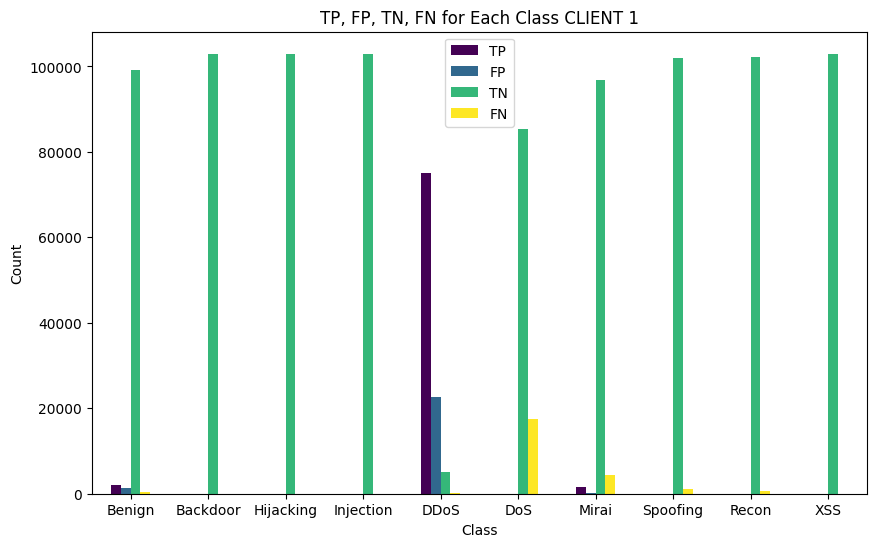

In [ ]:
# Client 1
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []
y_pred = []
Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3']
for index in range(len(Iterations)):
    y_pred_prob = models['client_1'][index].predict(X_tests['client_1'])

    y_pred = y_pred_prob.argmax(axis=1)
    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_1'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_1'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_1'], y_pred, average='weighted'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 1")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


cm = confusion_matrix(Y_tests['client_1'], y_pred)

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 1")

# Hiển thị
plt.show()


attack_types =["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]
metrics = []

# Số lượng lớp (10 lớp)
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(10, 6), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 1")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

4824/4824 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
  44/4824 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step   

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
  49/4824 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step   

c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4824/4824 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Precision Score:  [0.6188206755821727, 0.6616692043055066, 0.6256632705779858]
Recall Score:  [0.7521264535354517, 0.8018138826806595, 0.7561299517377644]
F1 Score:  [0.6555318805284236, 0.7191266591123548, 0.6596896071912095]


c:\Users\hoang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


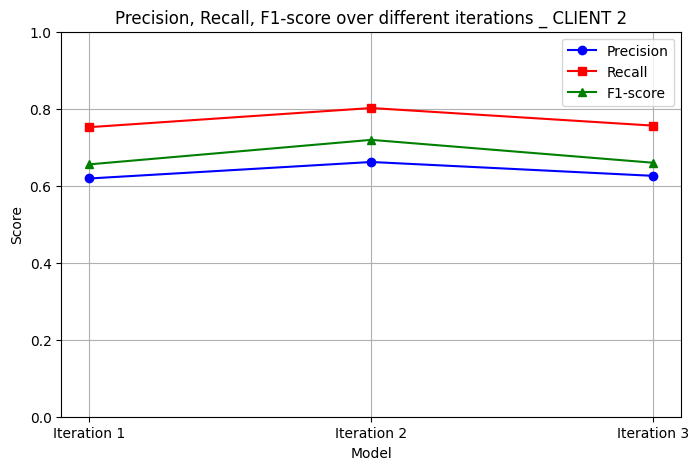

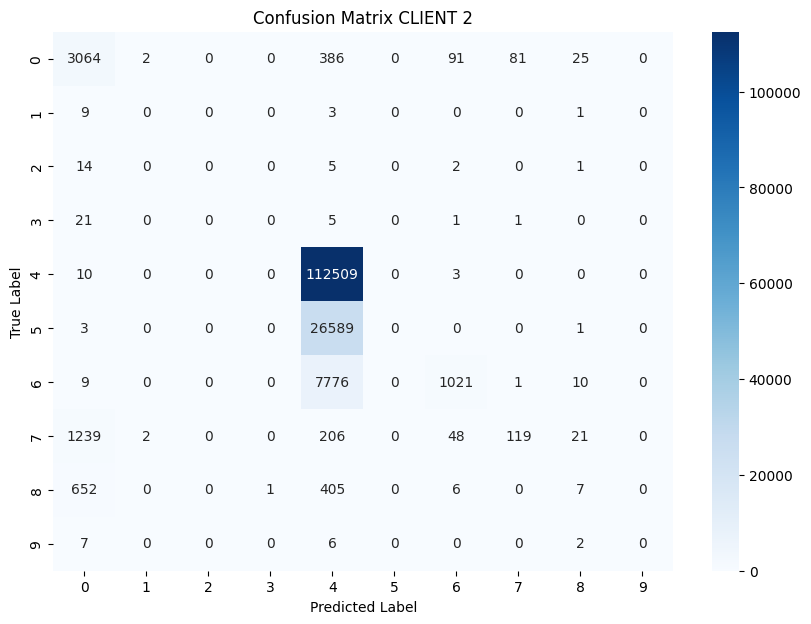

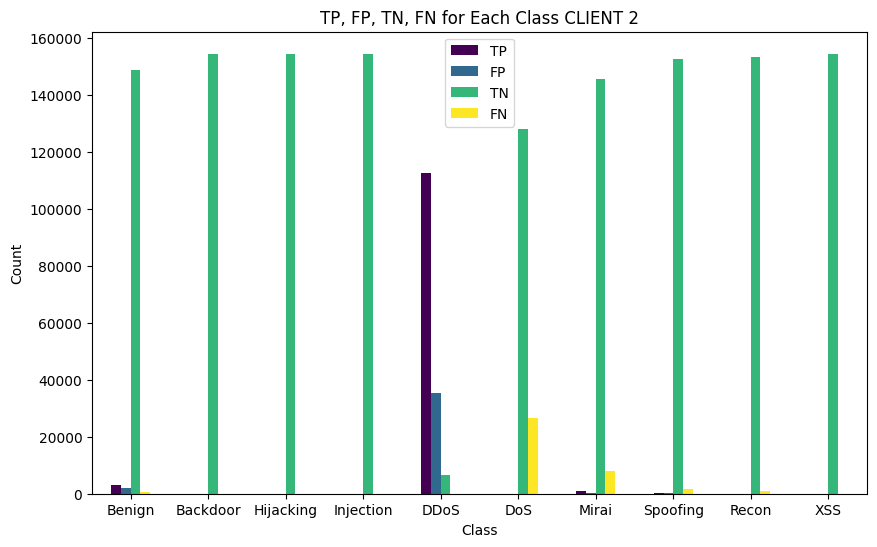

In [ ]:
# Client 2
import matplotlib.pyplot as plt

precisions = []
recalls = []
f1s = []
y_pred = []
Iterations = ['Iteration 1', 'Iteration 2', 'Iteration 3']
for index in range(len(Iterations)):
    y_pred_prob = models['client_2'][index].predict(X_tests['client_2'])

    y_pred = y_pred_prob.argmax(axis=1)

    # Tính Precision, Recall, F1-score
    precisions.append(precision_score(Y_tests['client_2'], y_pred, average='weighted'))
    recalls.append(recall_score(Y_tests['client_2'], y_pred, average='weighted'))
    f1s.append(f1_score(Y_tests['client_2'], y_pred, average='weighted'))
    
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)  

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(Iterations, precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations, recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations, f1s, marker='^', linestyle='-', label="F1-score", color='green')

# Thêm tiêu đề và nhãn
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 2")
plt.legend()
plt.ylim(0, 1)  # Giới hạn từ 0 đến 1
plt.grid(True)

# Hiển thị đồ thị
plt.show()


cm = confusion_matrix(Y_tests['client_2'], y_pred)
# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 2")

# Hiển thị
plt.show()


#
attack_types =["Benign", "Backdoor", "Hijacking", "Injection", "DDoS",  "DoS", 
                            "Mirai", "Spoofing", "Recon", "XSS"]
metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])

# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(10, 6), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class CLIENT 2")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7332394123077393 	 Loss: 0.8260282874107361
Epoch_1: Accuracy: 0.758216142654419 	 Loss: 0.7166650891304016
Epoch_2: Accuracy: 0.7608925700187683 	 Loss: 0.6982738375663757
Epoch_3: Accuracy: 0.7610103487968445 	 Loss: 0.6941430568695068
Epoch_4: Accuracy: 0.7611401677131653 	 Loss: 0.6889466643333435
Iteration 1: 
Epoch_0: Accuracy: 0.7398970723152161 	 Loss: 0.7816480994224548
Epoch_1: Accuracy: 0.7589716911315918 	 Loss: 0.710433304309845
Epoch_2: Accuracy: 0.7619751691818237 	 Loss: 0.69295734167099
Epoch_3: Accuracy: 0.761717677116394 	 Loss: 0.6876718401908875
Epoch_4: Accuracy: 0.7620770335197449 	 Loss: 0.6829438209533691
Iteration 2: 
Epoch_0: Accuracy: 0.7467150688171387 	 Loss: 0.7705791592597961
Epoch_1: Accuracy: 0.7597188353538513 	 Loss: 0.7060967683792114
Epoch_2: Accuracy: 0.7621172666549683 	 Loss: 0.6934173703193665
Epoch_3: Accuracy: 0.7618876099586487 	 Loss: 0.6874513030052185
Epoch_4: Accuracy: 0.7618139386177063 	 Loss: 0.68041

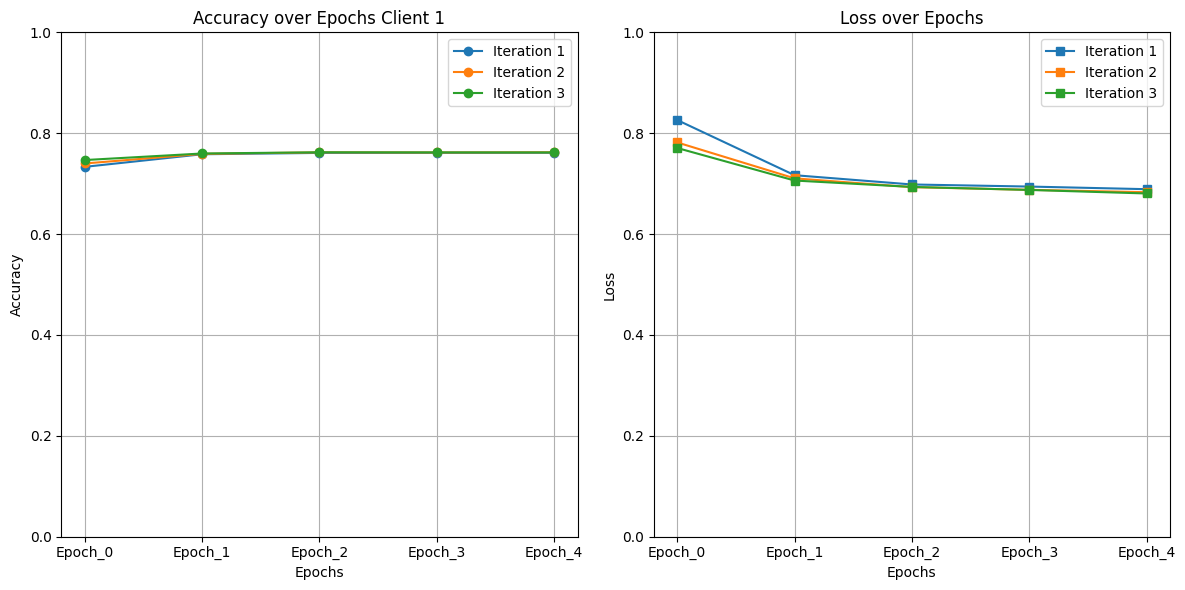

In [ ]:
# Client_0 
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_0_log/22h08p__25-03-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7441520094871521 	 Loss: 0.7800431847572327
Epoch_1: Accuracy: 0.7597604393959045 	 Loss: 0.7049620747566223
Epoch_2: Accuracy: 0.7615246176719666 	 Loss: 0.6933287382125854
Epoch_3: Accuracy: 0.7588609457015991 	 Loss: 0.6797979474067688
Epoch_4: Accuracy: 0.7565250396728516 	 Loss: 0.6744536757469177
Iteration 1: 
Epoch_0: Accuracy: 0.7519223690032959 	 Loss: 0.7438097596168518
Epoch_1: Accuracy: 0.7617146372795105 	 Loss: 0.690902829170227
Epoch_2: Accuracy: 0.7624527215957642 	 Loss: 0.6815375685691833
Epoch_3: Accuracy: 0.7573277354240417 	 Loss: 0.6717609763145447
Epoch_4: Accuracy: 0.7574261426925659 	 Loss: 0.6643138527870178
Iteration 2: 
Epoch_0: Accuracy: 0.7527638673782349 	 Loss: 0.7401202917098999
Epoch_1: Accuracy: 0.759777843952179 	 Loss: 0.6942973732948303
Epoch_2: Accuracy: 0.7609728574752808 	 Loss: 0.6744738817214966
Epoch_3: Accuracy: 0.7622946500778198 	 Loss: 0.6668649315834045
Epoch_4: Accuracy: 0.7596004009246826 	 Loss: 0.68

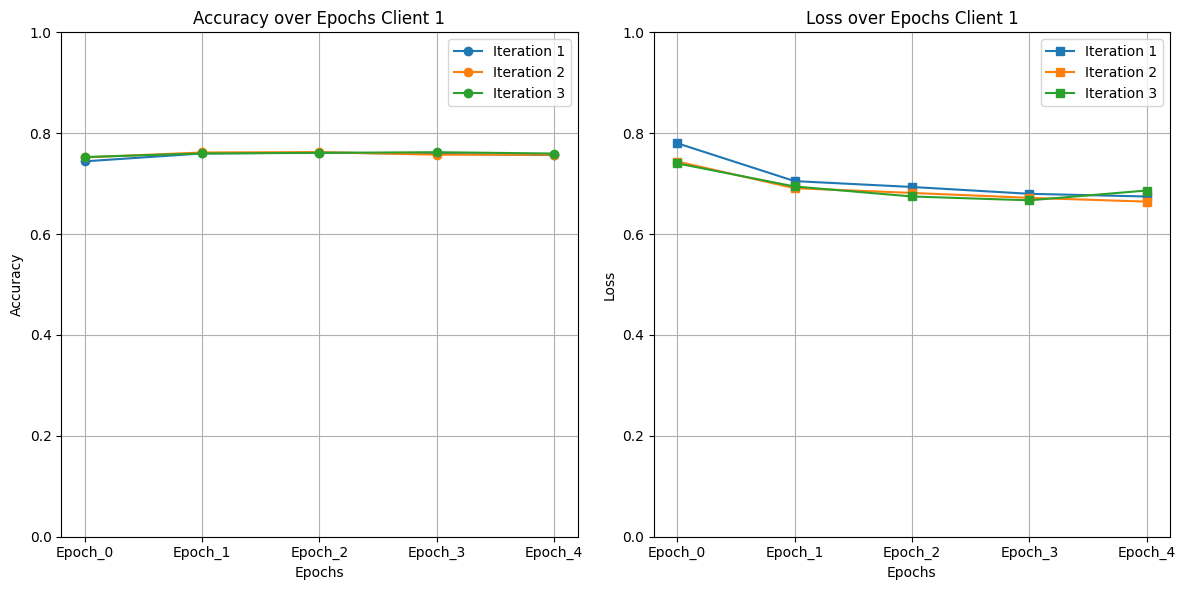

In [ ]:
# Client_1
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_1_log/22h08p__25-03-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 1")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

Iteration 0: 
Epoch_0: Accuracy: 0.7500243782997131 	 Loss: 0.7507213354110718
Epoch_1: Accuracy: 0.7612135410308838 	 Loss: 0.6896445751190186
Epoch_2: Accuracy: 0.7589588761329651 	 Loss: 0.6709281802177429
Epoch_3: Accuracy: 0.7580092549324036 	 Loss: 0.6745122075080872
Epoch_4: Accuracy: 0.7611063718795776 	 Loss: 0.6835665106773376
Iteration 1: 
Epoch_0: Accuracy: 0.7539124488830566 	 Loss: 0.7309588193893433
Epoch_1: Accuracy: 0.759954035282135 	 Loss: 0.6951293349266052
Epoch_2: Accuracy: 0.7585107684135437 	 Loss: 0.6742268800735474
Epoch_3: Accuracy: 0.7596746683120728 	 Loss: 0.6558783054351807
Epoch_4: Accuracy: 0.7651007771492004 	 Loss: 0.6735010743141174
Iteration 2: 
Epoch_0: Accuracy: 0.755957305431366 	 Loss: 0.7246091365814209
Epoch_1: Accuracy: 0.76112300157547 	 Loss: 0.6869326829910278
Epoch_2: Accuracy: 0.7593513131141663 	 Loss: 0.6736646294593811
Epoch_3: Accuracy: 0.7625070810317993 	 Loss: 0.6827905178070068
Epoch_4: Accuracy: 0.7602213621139526 	 Loss: 0.6848

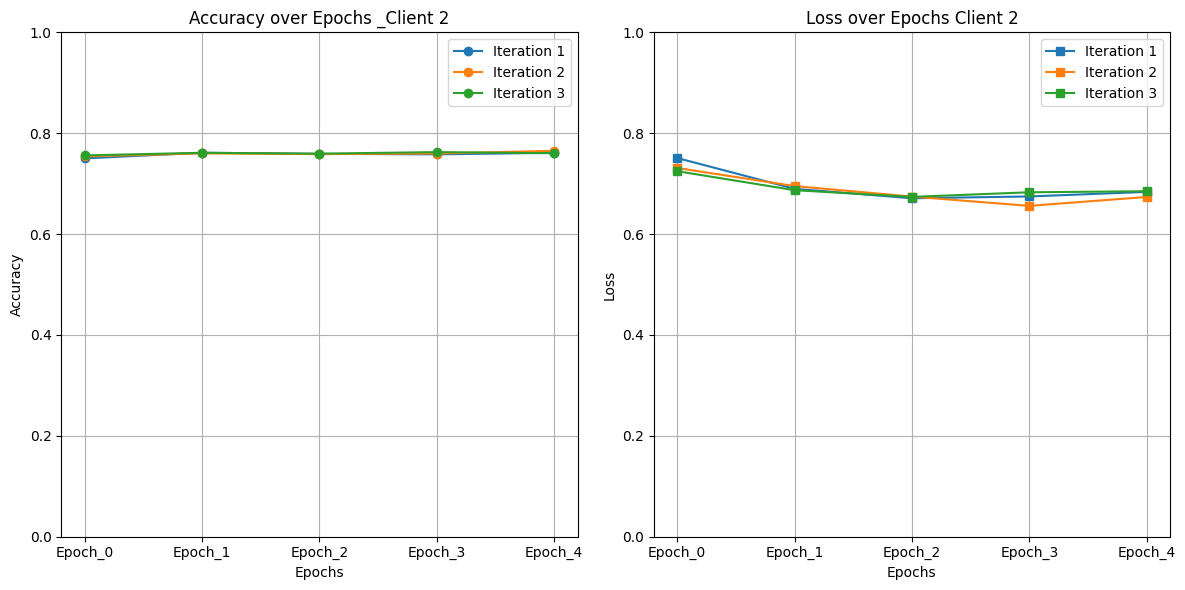

In [ ]:
# Client_2
import matplotlib.pyplot as plt
import numpy as np

file_dir= "client_2_log/22h08p__25-03-2025/"
file_names = ["Iteration_1.csv" ,"Iteration_2.csv", "Iteration_3.csv"]

import pandas as pd
import matplotlib.pyplot as plt

accuracy= []
loss = []
epochs = ["Epoch_"+str(i) for i in range(5)]
for i, file_name in enumerate(file_names):
    # Đọc file CSV
    df = pd.read_csv(file_dir + file_name)  # Đổi tên file nếu cần

    # Chuyển "NA" thành NaN và xử lý nếu cần
    df.replace("NA", None, inplace=True)

      # Đảm bảo epoch là số nguyên
    df["accuracy"] = df["accuracy"].astype(float)
    df["loss"] = df["loss"].astype(float)
    accuracy.append(df["accuracy"])
    loss.append(df["loss"])
    print("Iteration "+str(i)+": ")
    for epoch_index,  epoch in enumerate(epochs):
        print(epoch + f": Accuracy: {df['accuracy'][epoch_index]} \t Loss: {df['loss'][epoch_index]}")

plt.figure(figsize=(12, 6))

# Vẽ Accuracy
plt.subplot(1,2,1)
for i in range(3):
    plt.plot(epochs, accuracy[i], marker="o", linestyle="-", label=f"Iteration {i+1}")
    
plt.title("Accuracy over Epochs _Client 2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Vẽ Loss
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(epochs, loss[i], marker="s", linestyle="-", label=f"Iteration {i+1}")

plt.title("Loss over Epochs Client 2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()